In [5]:
import os
import cv2
import torch
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import load_coco_json
from pycocotools import mask as coco_mask
from shapely.geometry import Polygon
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
import pandas as pd
import numpy as np
import random
import torch.nn as nn
from PIL import Image
import PIL.ImageOps 
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [6]:
register_coco_instances(
    "wound_train",  # dataset name
    {},
    r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\Mask_coco_fixed.json",
    r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\train_pictures"
)

wound_metadata = MetadataCatalog.get("wound_train")
MetadataCatalog.get("wound_train").thing_classes = ["chronic", "burn", "trauma_blister"]
print("Classes:", MetadataCatalog.get("wound_train").thing_classes)

class CustomAugmentationMapper:
    def __init__(self, cfg, is_train=True):
        self.augmentations = [
            #aumenting the images - give the CNN more data to train with
            T.ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'),
            T.RandomFlip(horizontal=True),
            T.RandomBrightness(0.8, 1.2),
            T.RandomContrast(0.8, 1.2),
            T.RandomSaturation(0.8, 1.2),
        ]
        self.img_format = cfg.INPUT.FORMAT

    def __call__(self, dataset_dict):
        dataset_dict = dataset_dict.copy()
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        aug_input = T.AugInput(image)
        transforms = T.AugmentationList(self.augmentations)(aug_input)
        image = aug_input.image

        annos = [
            utils.transform_instance_annotations(obj, transforms, image.shape[:2])
            for obj in dataset_dict.pop("annotations")
        ]

        return {
            **dataset_dict,
            "image": torch.as_tensor(image.transpose(2, 0, 1).astype("float32")),
            "instances": utils.annotations_to_instances(annos, image.shape[:2])
        }

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(
            cfg,
            mapper=CustomAugmentationMapper(cfg, is_train=True),
            sampler=RepeatFactorTrainingSampler(cfg.DATASETS.TRAIN, repeat_thresh=0.05)
        )

# Create configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.DATASETS.TRAIN = ("wound_train",)
cfg.DATASETS.TEST = ()  

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Use pretrained COCO weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3 #threshold
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.SOLVER.BASE_LR = 0.00025 #learning rate
cfg.SOLVER.MAX_ITER = 5000 #iterations
cfg.SOLVER.STEPS = (2000, 4000)
cfg.SOLVER.GAMMA = 0.1
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.WARMUP_FACTOR = 0.001
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.TEST.EVAL_PERIOD = 1000



trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


import json
coco_json_path = r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\test-mask_coco_fixed.json"

with open(coco_json_path, 'r') as f:
    coco_dict = json.load(f)

image_id_to_filename = {img["id"]: img["file_name"] for img in coco_dict["images"]}
  
    # Build image ID
image_id_to_info = {img["id"]: img for img in coco_dict["images"]}

# Group annotations by file name
gt_by_image = {}
for ann in coco_dict["annotations"]:
    image_info = image_id_to_info[ann["image_id"]]
    file_name = image_info["file_name"]
    ann["height"] = image_info["height"]
    ann["width"] = image_info["width"]
    gt_by_image.setdefault(file_name, []).append(ann)

test_img_dir = r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\test_pictures"
output_dir = "./output/test_predictions"
os.makedirs(output_dir, exist_ok=True)
output_crops_dir = "./output/cropped_masks"
os.makedirs(output_crops_dir, exist_ok=True)


cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "./output/model_final.pth"

predictor = DefaultPredictor(cfg)

from shapely.geometry import Polygon

def mask_to_polygon(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        contour = contours[0].squeeze()

        #at least 4 points in the polygon
        if contour.ndim == 2 and len(contour) >= 4:
            return Polygon(contour)

    return None

def compute_iou(mask1, mask2):
    poly1 = mask_to_polygon(mask1)
    poly2 = mask_to_polygon(mask2)
    if poly1 is None or poly2 is None or not poly1.is_valid or not poly2.is_valid:
        return 0.0
    inter = poly1.intersection(poly2).area
    union = poly1.union(poly2).area
    return inter / union if union > 0 else 0

Classes: ['chronic', 'burn', 'trauma_blister']
[05/18 12:14:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_featu

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[05/18 12:14:57 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\CESCA\anaconda3\envs\detectron\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/18 12:15:17 d2.utils.events]:  eta: 0:46:37  iter: 19  total_loss: 2.48  loss_cls: 1.38  loss_box_reg: 0.2998  loss_mask: 0.694  loss_rpn_cls: 0.09404  loss_rpn_loc: 0.01024    time: 0.5664  last_time: 0.6144  data_time: 0.3268  last_data_time: 0.0015   lr: 9.7405e-06  max_mem: 2246M
[05/18 12:15:29 d2.utils.events]:  eta: 0:49:14  iter: 39  total_loss: 2.181  loss_cls: 1.131  loss_box_reg: 0.2961  loss_mask: 0.6794  loss_rpn_cls: 0.0499  loss_rpn_loc: 0.005791    time: 0.5772  last_time: 0.6267  data_time: 0.0049  last_data_time: 0.0011   lr: 1.973e-05  max_mem: 2273M
[05/18 12:15:40 d2.utils.events]:  eta: 0:45:50  iter: 59  total_loss: 1.772  loss_cls: 0.7887  loss_box_reg: 0.3329  loss_mask: 0.6422  loss_rpn_cls: 0.08881  loss_rpn_loc: 0.008371    time: 0.5666  last_time: 0.5387  data_time: 0.0170  last_data_time: 0.0020   lr: 2.972e-05  max_mem: 2273M
[05/18 12:15:51 d2.utils.events]:  eta: 0:45:39  iter: 79  total_loss: 1.565  loss_cls: 0.5331  loss_box_reg: 0.3537  loss_mask

In [7]:
test_img_dir = r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\test_pictures"
output_dir = "./output/test_predictions"
os.makedirs(output_dir, exist_ok=True)

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
predictor = DefaultPredictor(cfg)

from shapely.geometry import Polygon



# --- Evaluation ---
TP, FP, FN = 0, 0, 0
iou_thresh = 0.5
for img_file in os.listdir(test_img_dir):

    img_path = os.path.join(test_img_dir, img_file)
    img = cv2.imread(img_path)
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")
    pred_masks = instances.pred_masks.numpy() if instances.has("pred_masks") else []

    annos = gt_by_image.get(img_file, [])
    gt_masks = []
    for anno in annos:
        rle = coco_mask.frPyObjects(anno["segmentation"], anno["height"], anno["width"])
        m = coco_mask.decode(rle).astype(bool)
        gt_masks.append(m if m.ndim == 2 else m.any(axis=2))

    matched_gt = set()
    for pmask in pred_masks:
        matched = False
        for i, gmask in enumerate(gt_masks):
            if i in matched_gt:
                continue
            iou = compute_iou(pmask, gmask)
            if iou >= iou_thresh:
                TP += 1
                matched_gt.add(i)
                matched = True
                break
        if not matched:
            FP += 1

    FN += len(gt_masks) - len(matched_gt)
    
    v = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("wound_train"), scale=1.0)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    save_path = os.path.join(output_dir, f"pred_{img_file}")
    cv2.imwrite(save_path, out.get_image()[:, :, ::-1])
    print(f"Saved prediction: {save_path}")

# Metrics
precision = TP / (TP + FP) if (TP + FP) else 0
recall = TP / (TP + FN) if (TP + FN) else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
dice = 2 * TP / (2 * TP + FP + FN) if (TP + FP + FN) else 0

print(f"TP={TP}, FP={FP}, FN={FN}")
print(f"Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Dice={dice:.3f}")

    
test_img_dir = r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\test_pictures"
output_mask_dir = "./output/cropped_masks"
os.makedirs(output_mask_dir, exist_ok=True)

# Set up predictor
predictor = DefaultPredictor(cfg)

# Process each test image
for img_file in os.listdir(test_img_dir):
    img_path = os.path.join(test_img_dir, img_file)
    image = cv2.imread(img_path)

    if image is None:
        print(f"Could not read image: {img_file}")
        continue

    outputs = predictor(image)
    instances = outputs["instances"].to("cpu")

    if not instances.has("pred_masks"):
        continue

    pred_masks = instances.pred_masks.numpy()

    for i, mask in enumerate(pred_masks):
        mask_uint8 = (mask * 255).astype(np.uint8)

        # apply mask to original imaage
        masked_image = cv2.bitwise_and(image, image, mask=mask_uint8)

        # crop to just have the mask
        ys, xs = np.where(mask_uint8 > 0)
        if ys.size == 0 or xs.size == 0:
            continue  # Skip empty mask

        x1, y1, x2, y2 = xs.min(), ys.min(), xs.max(), ys.max()
        cropped = masked_image[y1:y2, x1:x2]

        # save cropped mask image
        base_name = os.path.splitext(img_file)[0]
        save_name = f"{base_name}_mask_{i}.png"
        save_path = os.path.join(output_mask_dir, save_name)
        cv2.imwrite(save_path, cropped)
        print(f"Saved: {save_path}")



[05/18 13:03:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Saved prediction: ./output/test_predictions\pred_016.1.JPG
Saved prediction: ./output/test_predictions\pred_025.1.JPG
Saved prediction: ./output/test_predictions\pred_028.1.JPG
Saved prediction: ./output/test_predictions\pred_031.1.JPG
Saved prediction: ./output/test_predictions\pred_033.1.JPG
Saved prediction: ./output/test_predictions\pred_038.1.JPG
Saved prediction: ./output/test_predictions\pred_039.1.JPG
Saved prediction: ./output/test_predictions\pred_053.1.JPG
Saved prediction: ./output/test_predictions\pred_079.1.JPG
Saved prediction: ./output/test_predictions\pred_084.1.JPG
Saved prediction: ./output/test_predictions\pred_086.1.JPG
Saved prediction: ./output/test_predictions\pred_092.1.JPG
Saved prediction: ./output/test_predictions\pred_099.1.JPG
Saved prediction: ./output/test_predictions\pred_119.1.JPG
Saved prediction: ./output/test_predictions\pred_120.1.

In [8]:
crop_folder = "output/cropped_masks"
output_json = "output/crop_metadata.json"

In [9]:
register_coco_instances(
    "wound_test",
    {},
    r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\test-mask_coco_fixed.json",
    r"C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\test_pictures"
)

cfg.DATASETS.TEST = ("wound_test",)

evaluator = COCOEvaluator("wound_test", cfg, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "wound_test")
results = inference_on_dataset(trainer.model, val_loader, evaluator)
print(results)

PRED_JSON = "./output/coco_instances_results.json"
IMAGE_DIR = "./output/test_predictions"
OUTPUT_DIR = "wound_output"
CROP_SIZE =(224, 224)
CONF_THRESH = 0.5


WARNING [05/18 13:03:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/18 13:03:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/18 13:03:45 d2.data.datasets.coco]: Loaded 16 images in COCO format from C:\Users\CESCA\OneDrive - University of Brighton\Desktop\systems2\test-mask_coco_fixed.json
[05/18 13:03:45 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |   category    | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-------------:|:-------------|
|  chronic   | 38           |    burn    | 2            | trauma_blis.. | 8            |
|            |              |            |              |               |              |
|   total    | 48           |            |              |               |            

In [13]:

def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

"""class SiameseNetworkDataset(Dataset):
    def __init__(self,crop_folder, transform=None):
        self.crop_folder = crop_folder
        #set the image folder so the class knows where its getting the data from. 
        #self.transform = transform
        #transform the images to crop them and reduce the file size
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.image_paths = [
            os.path.join(crop_folder, f)
            for f in os.listdir(crop_folder)
            if f.lower().endswith(('.png', '.jpg', ''))
        ]
        #this was used to get the sizes to optimise the cnn and fcl functions. 
        #self.getsizes()

    def __getitem__(self, index):
        # image 0 is a random image from the set
        img0_tuple = random.choice(self.image_paths)
        
        #this would print what the image file and number is
        #print("img0 = "+ img0_tuple[0][32:])
        
        #we then split the path to get a list of [class (patient id), file name]
        img0_split = img0_tuple[0].split("/")
        img0_class = img0_split[2].split("\\")
        #print("img0 = ", img0_class)

        #roughly half images should be the same
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            #copy the list to randomise it
            randomlist = self.image_paths
            #and shuffle said list
            random.shuffle(randomlist)

            #go through every item in list until one from same class, but a different image is found
            for i in range(self.__len__()):
                #print(randomlist[i])
                #split path name again, same format as image 0
                randomlist_split = randomlist[i][0].split("/")
                img1_class = randomlist_split[2].split("\\")
                #print(img1_class)

                #if patient id is same but its not the same image, that becomes image 1 and we stop looping
                if img1_class[0] == img0_class[0] and img1_class[1]!=img0_class[1]:

                #   if list2[i][0][32:-10] == img0_tuple[0][32:-10] and list2[i][0] != img0_tuple[0]:
                    img1_tuple = randomlist[i]
                    #print("break")
                    break
        else:
            while True:
                #finding image from different class
                img1_tuple = random.choice(self.image_paths)
                #print("diff: img 1 = "+img1_tuple[0][32:])
                img1_class = img1_tuple[0].split("/")
                img1_class = img1_class[2].split("\\")

                if img0_class[0] != img1_class[0]:
                    break

        #open both images
        img0 = Image.open(img0_tuple[0]).convert('RGB')
        img1 = Image.open(img1_tuple[0]).convert('RGB')

        #transform the images, based on the transformation input
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        #print(img0_class[0]," image 0 class")
        #print(img1_class[0], " image 1 clas")
        #print(torch.from_numpy(np.array([int(img1_class[0] != img0_class[0])], dtype=np.float32))," number\n")
        #this was to check the transformations were working
        #self.getsize(img1)
        #width, height = img0.size
        #print("0 = W:",width,"H:",height)   
        #width, height = img1.size
        #print("1 = W:",width,"H:",height) 
        #self.getsize(img0)

        #returns the 2 images and the number of weather they belong to the same category or not
        return img0, img1, torch.from_numpy(np.array([int(img1_class[0] != img0_class[0])], dtype=np.float32))
"""

class SiameseNetworkDataset(Dataset):
    def __init__(self, crop_folder, transform=None):
        self.crop_folder = crop_folder
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        # List all image paths
        self.image_paths = [
            os.path.join(crop_folder, f)
            for f in os.listdir(crop_folder)
            if f.lower().endswith(('.png', '.JPG'))
        ]

        # Group by original image ID
        self.groups = {}
        for path in self.image_paths:
            filename = os.path.basename(path)
            image_id = filename.split('_')[0]
            self.groups.setdefault(image_id, []).append(path)

        self.image_ids = list(self.groups.keys())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Pick anchor image
        anchor_path = self.image_paths[index]
        anchor_filename = os.path.basename(anchor_path)
        anchor_id = anchor_filename.split('_')[0]

        should_get_same = random.randint(0, 1)

        if should_get_same and len(self.groups[anchor_id]) > 1:
            # Pick another crop from the same image
            possible = [p for p in self.groups[anchor_id] if p != anchor_path]
            pair_path = random.choice(possible)
            label = 0.0
        else:
            # Pick a crop from a different image
            other_ids = [id_ for id_ in self.image_ids if id_ != anchor_id]
            other_id = random.choice(other_ids)
            pair_path = random.choice(self.groups[other_id])
            label = 1.0

        img0 = Image.open(anchor_path).convert("RGB")
        img1 = Image.open(pair_path).convert("RGB")

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.tensor([label], dtype=torch.float32)


    def __len__(self):
        return len(self.image_paths)
    
    def setTransforms(self):
        #the set of transformations, crops in the centre, and the makes the image smaller, then makes it a tensor
        self.transform = transforms.Compose([
        transforms.CenterCrop(2000),
        transforms.Resize(size = (300,300)),
        transforms.ToTensor()
        ])

    #functions to get the sizes
    def getsize(self, img):
        width, height = img.size
        print("W:",width,"H:",height)
        
    def getsizes(self):
        for i in self.image_pathsr:
            width, height = i.size
            print("W:",width,"H:",height)

dataset = SiameseNetworkDataset("output/cropped_masks")

dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)  # use 0 for debuggin

test_dataset = SiameseNetworkDataset("output/cropped_masks")



Using device: cuda
1

2

3

Flatten size: 35443
4

5
Epoch:  0 
Current loss: 3.9972903728485107
Epoch:  0 
Current loss: 0.8980519771575928
7
5
Epoch:  1 
Current loss: 0.3042261004447937
Epoch:  1 
Current loss: 2.608407497406006
7
5
Epoch:  2 
Current loss: 1.6321899890899658
Epoch:  2 
Current loss: 0.0
7
5
Epoch:  3 
Current loss: 0.4275408983230591
Epoch:  3 
Current loss: 0.29280394315719604
7
5
Epoch:  4 
Current loss: 1.604379653930664
Epoch:  4 
Current loss: 0.3119475245475769
7
5
Epoch:  5 
Current loss: 0.7918566465377808
Epoch:  5 
Current loss: 0.06200611963868141
7
5
Epoch:  6 
Current loss: 1.7241613864898682
Epoch:  6 
Current loss: 0.7291451692581177
7
5
Epoch:  7 
Current loss: 1.262223243713379
Epoch:  7 
Current loss: 1.1012053489685059
7
5
Epoch:  8 
Current loss: 0.8411930799484253
Epoch:  8 
Current loss: 0.1285492330789566
7
5
Epoch:  9 
Current loss: 2.571925640106201
Epoch:  9 
Current loss: 0.0
7
5
Epoch:  10 
Current loss: 1.822513222694397
Epoch:  10 
Cur

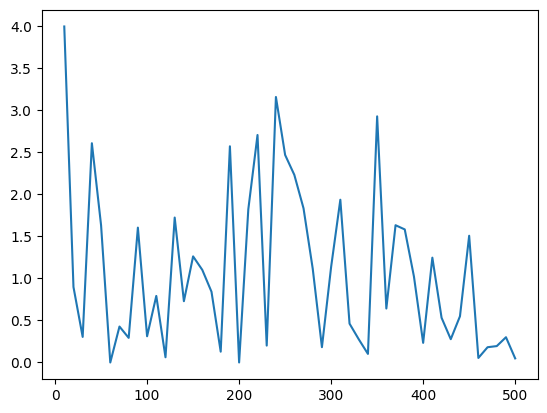

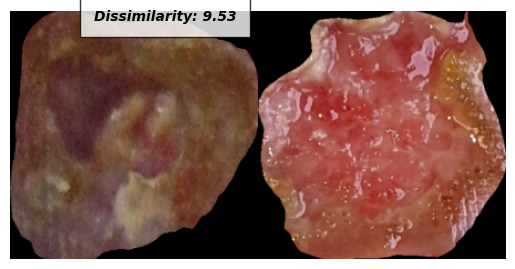

Dissimilarity to image 0: 9.53


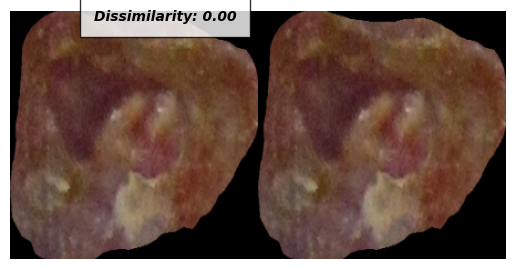

Dissimilarity to image 0: 0.00


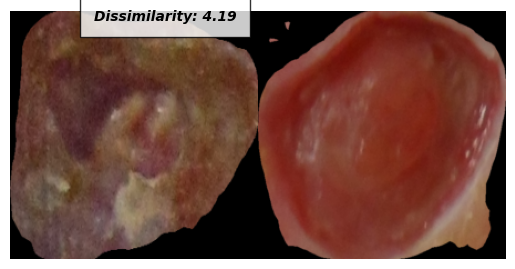

Dissimilarity to image 0: 4.19


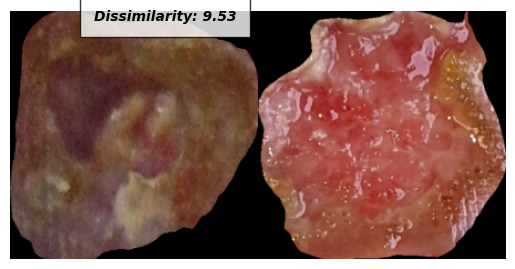

Dissimilarity to image 0: 9.53


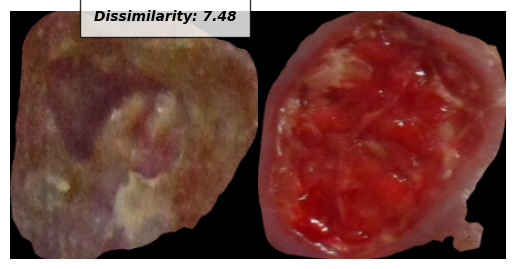

Dissimilarity to image 0: 7.48


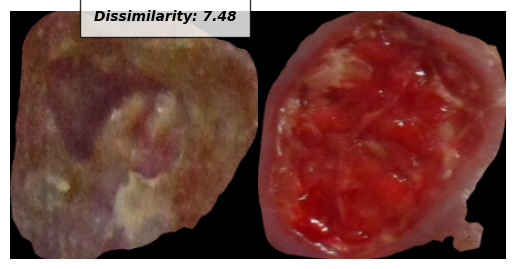

Dissimilarity to image 0: 7.48


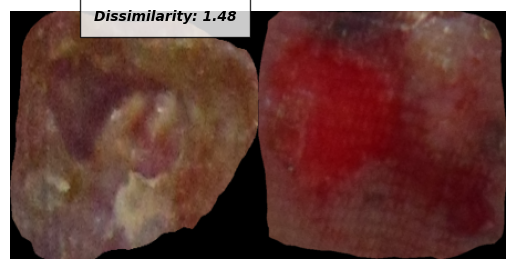

Dissimilarity to image 0: 1.48


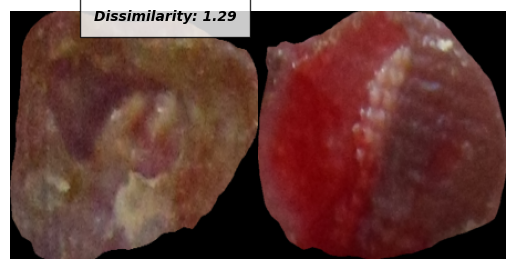

Dissimilarity to image 0: 1.29


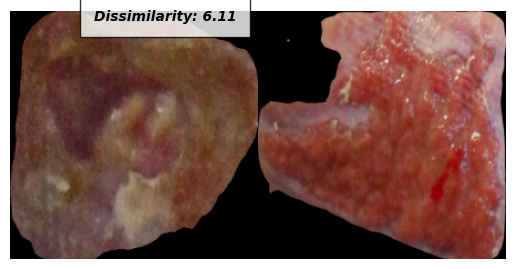

Dissimilarity to image 0: 6.11


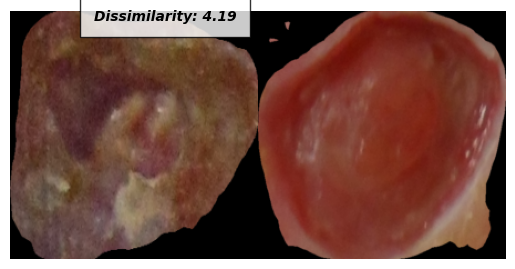

Dissimilarity to image 0: 4.19


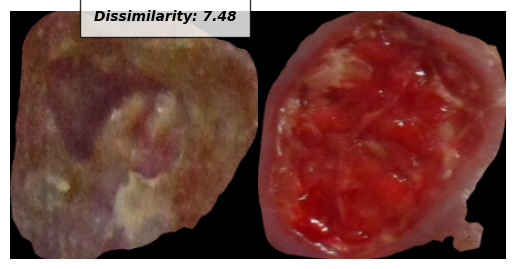

Dissimilarity to image 0: 7.48


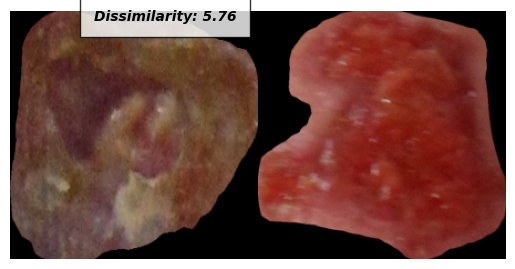

Dissimilarity to image 0: 5.76


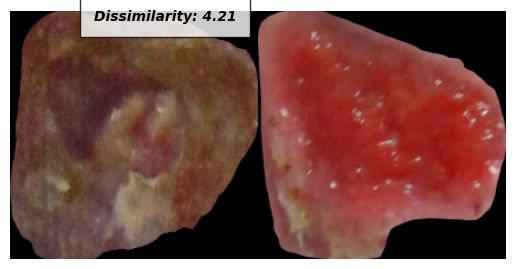

Dissimilarity to image 0: 4.21


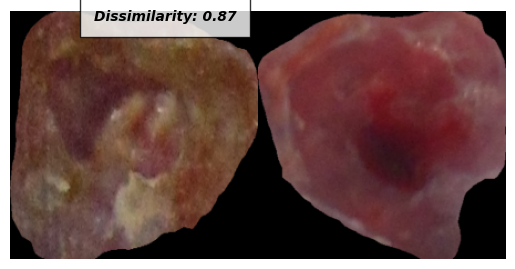

Dissimilarity to image 0: 0.87


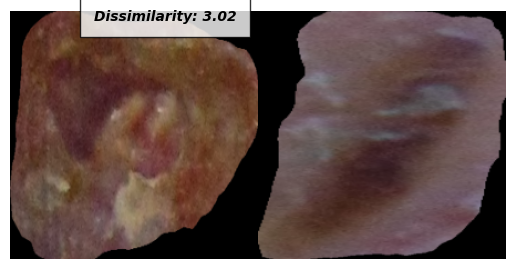

Dissimilarity to image 0: 3.02


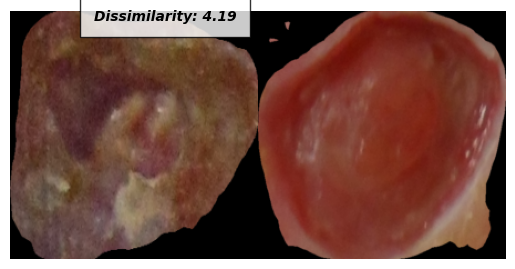

Dissimilarity to image 0: 4.19


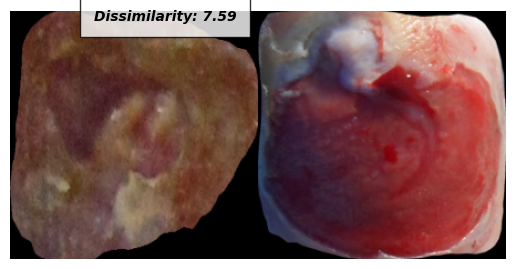

Dissimilarity to image 0: 7.59


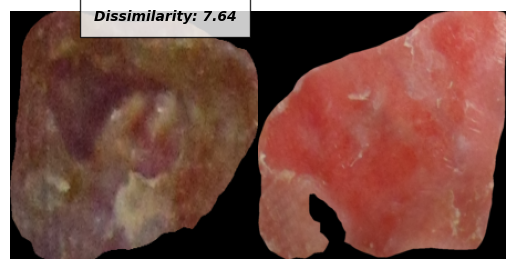

Dissimilarity to image 0: 7.64


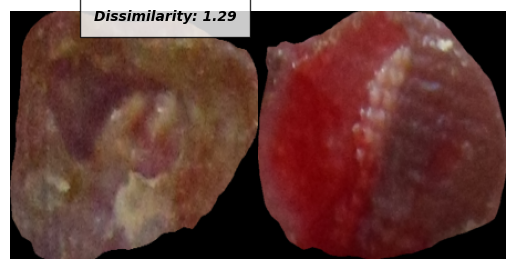

Dissimilarity to image 0: 1.29


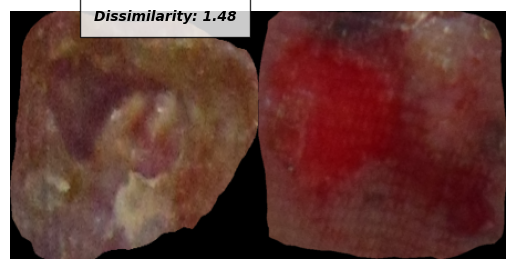

Dissimilarity to image 0: 1.48


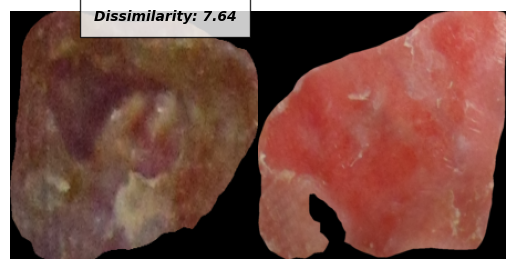

Dissimilarity to image 0: 7.64


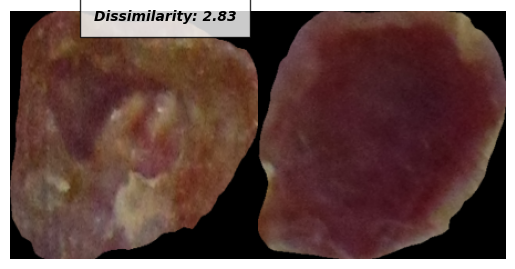

Dissimilarity to image 0: 2.83


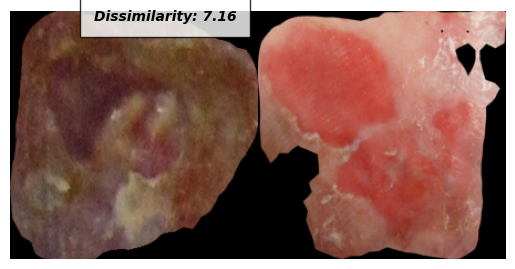

Dissimilarity to image 0: 7.16


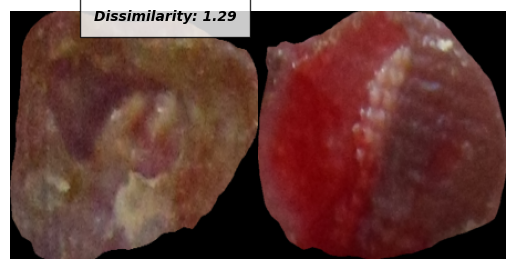

Dissimilarity to image 0: 1.29
10


In [66]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        #the first number is 3 because of the images are rgb.
        #the first number in the second conv2d, is the second number in the first one
        
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(3,143,kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride = 2),

            nn.Conv2d(143, 1206, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride = 2),

            nn.Conv2d(1206, 67, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride = 2)

        )

        dummy_input = torch.zeros(1, 3, 224, 224)
        dummy_output = self.cnn1(dummy_input)
        flatten_size = dummy_output.view(1, -1).size(1)
        print(f"Flatten size: {flatten_size}")

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(flatten_size, 3097),
            nn.ReLU(inplace=True),
            
            nn.Linear(3097, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        """
        # Setting up the Sequential of CNN Layers, these changed a lot. so i saved one that worked befor i chaneged it a lot
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3),
            nn.ReLU(inplace=True)
        )
        """

    def forward_once(self, x):
        # This function will be called for both images
        # applying the layers we defined above, use this to find the similarity.
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output
    
    def forward(self, input1, input2):
        # In this function we pass in both images and get both vectors
        # which are returned
        vector1 = self.forward_once(input1)
        vector2 = self.forward_once(input2)

        return vector1, vector2

# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
      
      return loss_contrastive
    
#the print statements are to see how far the code gets if it crashes

#training data folder set
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

folder_dataset = datasets.ImageFolder("output")
print("1\n")
siamese_dataset = SiameseNetworkDataset("output/cropped_masks")
print("2\n")
test_dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1 , shuffle=True)
#the method of training the data
"""train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                         num_workers=8,
                        batch_size=8)
"""
print("3\n")
#all the .cpus can be changed to .gpu, which will run quicker, but it doesnt work on my gpu
net = SiameseNetwork().to(device)
loss = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )
print("4\n")
counter = []
loss_history = [] 
iteration_number= 0

##when using multi threading in windows, this needs to be included so a runtime error doesnt occur
if __name__ == '__main__':
    # Iterate throught the epochs
    
    #more epochs = more training and more learnt
    for epoch in range(25):
        print("5")
        # Iterate over batches
        for i, (img0, img1, label) in enumerate(dataloader, 0):

            
            #there is avaliability to send to gpu if compatable, but my laptop doesnt do that.
            img0, img1, label = img0.to(device), img1.to(device), label.to(device)
            
            # make the gradients 0 to start
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = net(img0, img1)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = loss(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Every 10 batches print out the loss to see what its doing
            if i % 10 == 0 :
                print( "Epoch: ",epoch,"\nCurrent loss:",loss_contrastive.item())
                iteration_number += 10

                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
        print("7")

    #would plot the loss, on a graph
    show_plot(counter, loss_history)

 # Locate the test dataset and load it into the SiameseNetworkDataset
    # Grab one image that we are going to test
    #this would be the inputted image, in the final system
    dataiter = iter(test_dataloader)
    x0, _, _ = next(dataiter)  # Fixed image
    img0 = x0[0].to(device) 

    for _ in range(24):  
        _, x1_batch, _ = next(dataiter)  

        for j in range(x1_batch.size(0)):  
            x1 = x1_batch[j].unsqueeze(0).to(device) 

            # Pass both through network
            output1, output2 = net(img0.unsqueeze(0), x1)
            distance = F.pairwise_distance(output1, output2)

            # Visualization
            pair_vis = torch.cat((img0, x1.squeeze(0)), dim=2)
            imshow(torchvision.utils.make_grid(pair_vis.cpu()), f"Dissimilarity: {distance.item():.2f}")
            print(f"Dissimilarity to image {j}: {distance.item():.2f}")
    """for i in range(15):

        # Iterate over 10 images and test them with the first image (x0)
        _, x1, label2 = next(dataiter)
        #weather the images are the same or different classes so you dont have to see each image
        #label is 1 they are different classes
        #label is 0 they are the same class
        #print("WHAAT::",next(dataiter))
        #print("\n",next(dataiter)[2].numpy().reshape(-1)) 
        #print(label2 ," final label")
        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)
        
        output1, output2 = net(x0.cpu(), x1.cpu())
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        #can show images with this one
        imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

        print("Dissimilarity: ",euclidean_distance.item())
    """
print("10")
